# Shallow Neural Network on 2D Data

Note the *2D* part refers to the ball is being shot from a point to different points in the goal, **not** that the input features are 2D. In fact, the input features are 4D `[x, y, dx, dy]` vectors

### Load Data

In [46]:
%store -r many_many_short

df = many_many_short
sideways = df.T

X, Y = np.array(sideways['x':'dy']).astype(float), np.array(sideways.ix['label']).astype(int)

### Train

In [47]:
from nn.deep.model import NeuralNetwork

nn = NeuralNetwork(X, Y, Hs=[5], C=2, learning_rate=.1, regularizer=0.001, gradient_checking=False, inspect=True)

def states(iters):
    for i in range(iters):
        if not i % 100:
            print('{}%...'.format((i/float(iters)) * 100))
            
        nn.learn()
        yield nn.info
        
states = list(states(10000))

0.0%...
1.0%...
2.0%...
3.0%...
4.0%...
5.0%...
6.0%...
7.0%...
8.0%...
9.0%...
10.0%...
11.0%...
12.0%...
13.0%...
14.0%...
15.0%...
16.0%...
17.0%...
18.0%...
19.0%...
20.0%...
21.0%...
22.0%...
23.0%...
24.0%...
25.0%...
26.0%...
27.0%...
28.0%...
29.0%...
30.0%...
31.0%...
32.0%...
33.0%...
34.0%...
35.0%...
36.0%...
37.0%...
38.0%...
39.0%...
40.0%...
41.0%...
42.0%...
43.0%...
44.0%...
45.0%...
46.0%...
47.0%...
48.0%...
49.0%...
50.0%...
51.0%...
52.0%...
53.0%...
54.0%...
55.0%...
56.0%...
57.0%...
58.0%...
59.0%...
60.0%...
61.0%...
62.0%...
63.0%...
64.0%...
65.0%...
66.0%...
67.0%...
68.0%...
69.0%...
70.0%...
71.0%...
72.0%...
73.0%...
74.0%...
75.0%...
76.0%...
77.0%...
78.0%...
79.0%...
80.0%...
81.0%...
82.0%...
83.0%...
84.0%...
85.0%...
86.0%...
87.0%...
88.0%...
89.0%...
90.0%...
91.0%...
92.0%...
93.0%...
94.0%...
95.0%...
96.0%...
97.0%...
98.0%...
99.0%...


### Plot Losses

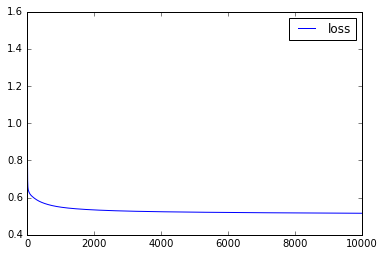

In [48]:
def loss_averages():
    for state in states:
        yield state.gradients['loss'].mean()
        
loss_avgs = list(loss_averages())

pd.DataFrame(loss_avgs, columns=['loss']).plot()

### Visualize

Notice the plots are linear because of the following recurrence relation:

$$v_t = x_{t+1} - x_t$$

This formula follows by definition of $x_t$:

$$x_t = x_{t-1} + v_{t-1}$$

Intuitively, as the difference between $x$ points gets smaller, the difference between $y$ points get smaller **by the same amount**

/home/ebanner/.anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


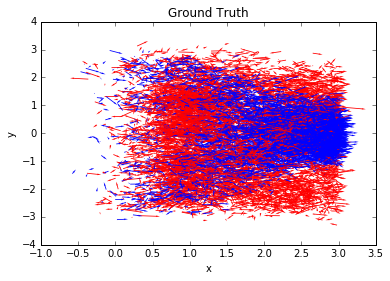

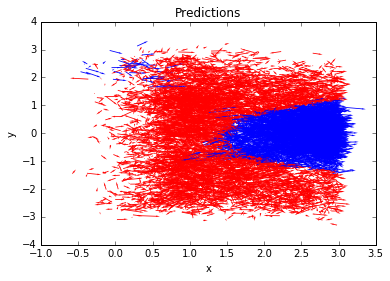

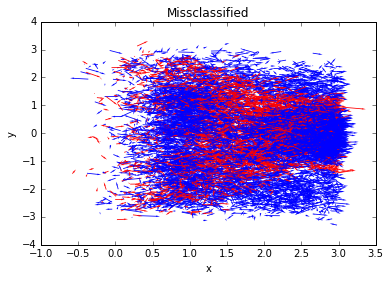

In [49]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), df=fixed(df), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, df, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    nn = NeuralNetwork(X, ys_train=Y, Hs=[5], C=2, params=s.params)
    
    # Plotting
    colormap = np.array(['r', 'b'])
    
    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

    # Predictions
    df['predictions'] = nn.predict(X)
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

In [50]:
df['correct'].sum().astype(float) / len(df)

0.74865241354248679

### Serialize Model

In [51]:
import pickle

nn = NeuralNetwork(X[:,:1], Y[:1], Hs=[5], C=2, params=states[-1].params)

model = {'clf': nn, 'features': 'position+velocity', 'window_size': None}

with open('/home/ebanner/nao/trunk/core/python/behaviors/model.py', 'wb') as f:
    pickle.dump(model, f)